<a href="https://colab.research.google.com/github/MICHAEL121233/VLP-Performance-Prediction/blob/main/Machine_Learning_Based_Optimization_of_GasLift_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oil wells often require artificial lift mechanisms to maintain or increase production as reservoir pressure declines. Gas lift is a widely adopted artificial lift technique that involves injecting gas into the tubing to reduce the hydrostatic pressure, enabling reservoir fluids to flow more easily to the surface. Traditional gas lift design relies on empirical analysis and iterative simulations, which can be time-consuming. However, with the increasing availability of well data and advanced simulation software such as PROSPER, it is now feasible to apply data-driven approaches such as machine learning to analyze complex interactions and predict optimal lift parameters. This research explores the use of ML techniques to predict vertical lift performance (VLP) pressure as a function of various well parameters, ultimately aiming to identify optimal gas injection rates for maximizing oil production. This study not only enhances lift efficiency but also lays the foundation for data-informed decision-making in petroleum production operations.
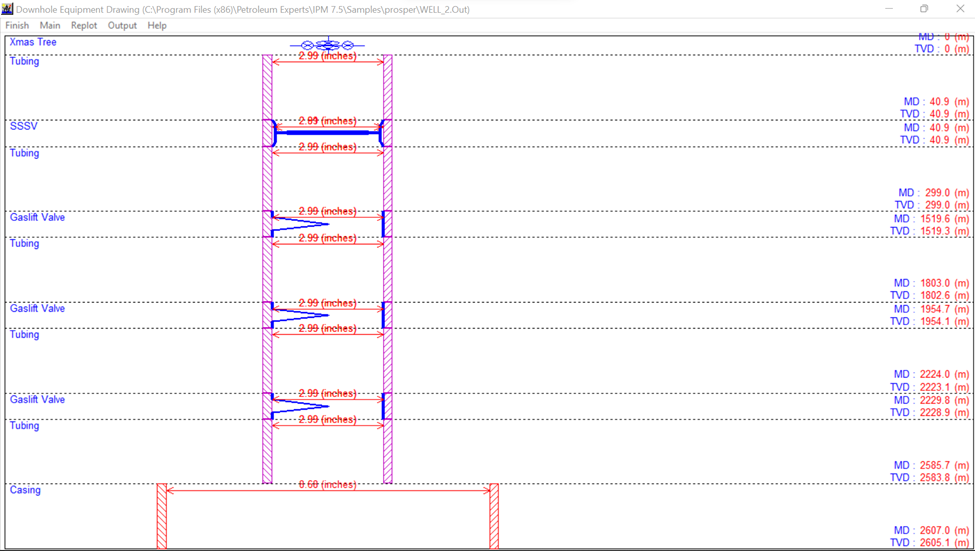

# IMPORTS AND DATA LOADING/CLEANING

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and Clean Data
df = pd.read_excel("/content/WELL_DATASET.xlsx")

# Drop rows with nulls
df.dropna(inplace=True)

# resetting the index
df.reset_index(drop=True, inplace=True)

# preview
df.head()

,Liquid Rate (STB/day),Oil Rate (STB/day),VLP Pressure (psig),IPR Pressure (psig),WellHead Pressure (psig),WellHead Temperature (deg F),dP Friction (psi),dP Gravity (psi),Injection Depth (feet),Gas Injection Rate (MMscf/day),Water Cut (%)
0,5.3,1.9,3944.02,3872.41,261.0,85.10,0.025079,3682.99,0.0,0.0,65.0
1,284.0,99.4,3354.14,3736.46,261.0,90.13,4.370000,3066.95,0.0,0.0,65.0
2,562.7,196.9,3222.18,3600.51,261.0,95.11,14.610000,2924.31,0.0,0.0,65.0
3,841.4,294.5,3213.89,3464.48,261.0,99.86,29.490000,2908.57,0.0,0.0,65.0
4,1120.1,392.0,3225.05,3327.13,261.0,104.17,48.580000,2904.60,0.0,0.0,65.0


# EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis (EDA) is the process of visually and statistically analyzing your dataset before applying any machine learning model. The aim is to understand the structure, detect anomalies, uncover patterns, and check relationships between variables, all of which guide model building and feature engineering.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Liquid Rate (STB/day)           240 non-null    float64
 1   Oil Rate (STB/day)              240 non-null    float64
 2   VLP Pressure (psig)             240 non-null    float64
 3   IPR Pressure (psig)             240 non-null    float64
 4   WellHead Pressure (psig)        240 non-null    float64
 5   WellHead Temperature (deg F)    240 non-null    float64
 6   dP Friction (psi)               240 non-null    float64
 7   dP Gravity (psi)                240 non-null    float64
 8   Injection Depth (feet)          240 non-null    float64
 9   Gas Injection Rate (MMscf/day)  240 non-null    float64
 10  Water Cut (%)                   240 non-null    float64
dtypes: float64(11)
memory usage: 20.8 KB


In [4]:
df.describe()

,Liquid Rate (STB/day),Oil Rate (STB/day),VLP Pressure (psig),IPR Pressure (psig),WellHead Pressure (psig),WellHead Temperature (deg F),dP Friction (psi),dP Gravity (psi),Injection Depth (feet),Gas Injection Rate (MMscf/day),Water Cut (%)
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.0000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2009.574167,1082.810344,2994.679875,2313.201250,343.666667,108.4080,141.882422,2499.959333,599.186667,0.925000,46.833333
std,1376.016966,881.925194,649.037303,1023.384115,171.319923,12.2578,164.594940,545.992148,937.670024,0.972531,22.223036
min,2.200000,0.541310,900.190000,7.710000,185.000000,85.0400,0.003559,665.280000,0.000000,0.000000,15.000000
25%,840.275000,364.250000,2770.717500,1666.817500,228.000000,98.6100,29.130000,2286.120000,0.000000,0.000000,20.000000
50%,1833.800000,919.350000,3112.090000,2460.515000,276.500000,109.4900,84.170000,2576.325000,0.000000,0.600000,53.000000
75%,3018.325000,1637.675000,3410.260000,3135.795000,400.000000,117.9075,182.095000,2939.830000,845.700000,1.800000,65.000000
max,5300.600000,3928.100000,4061.470000,3874.650000,696.000000,131.9600,721.390000,3692.290000,4215.200000,2.300000,75.000000


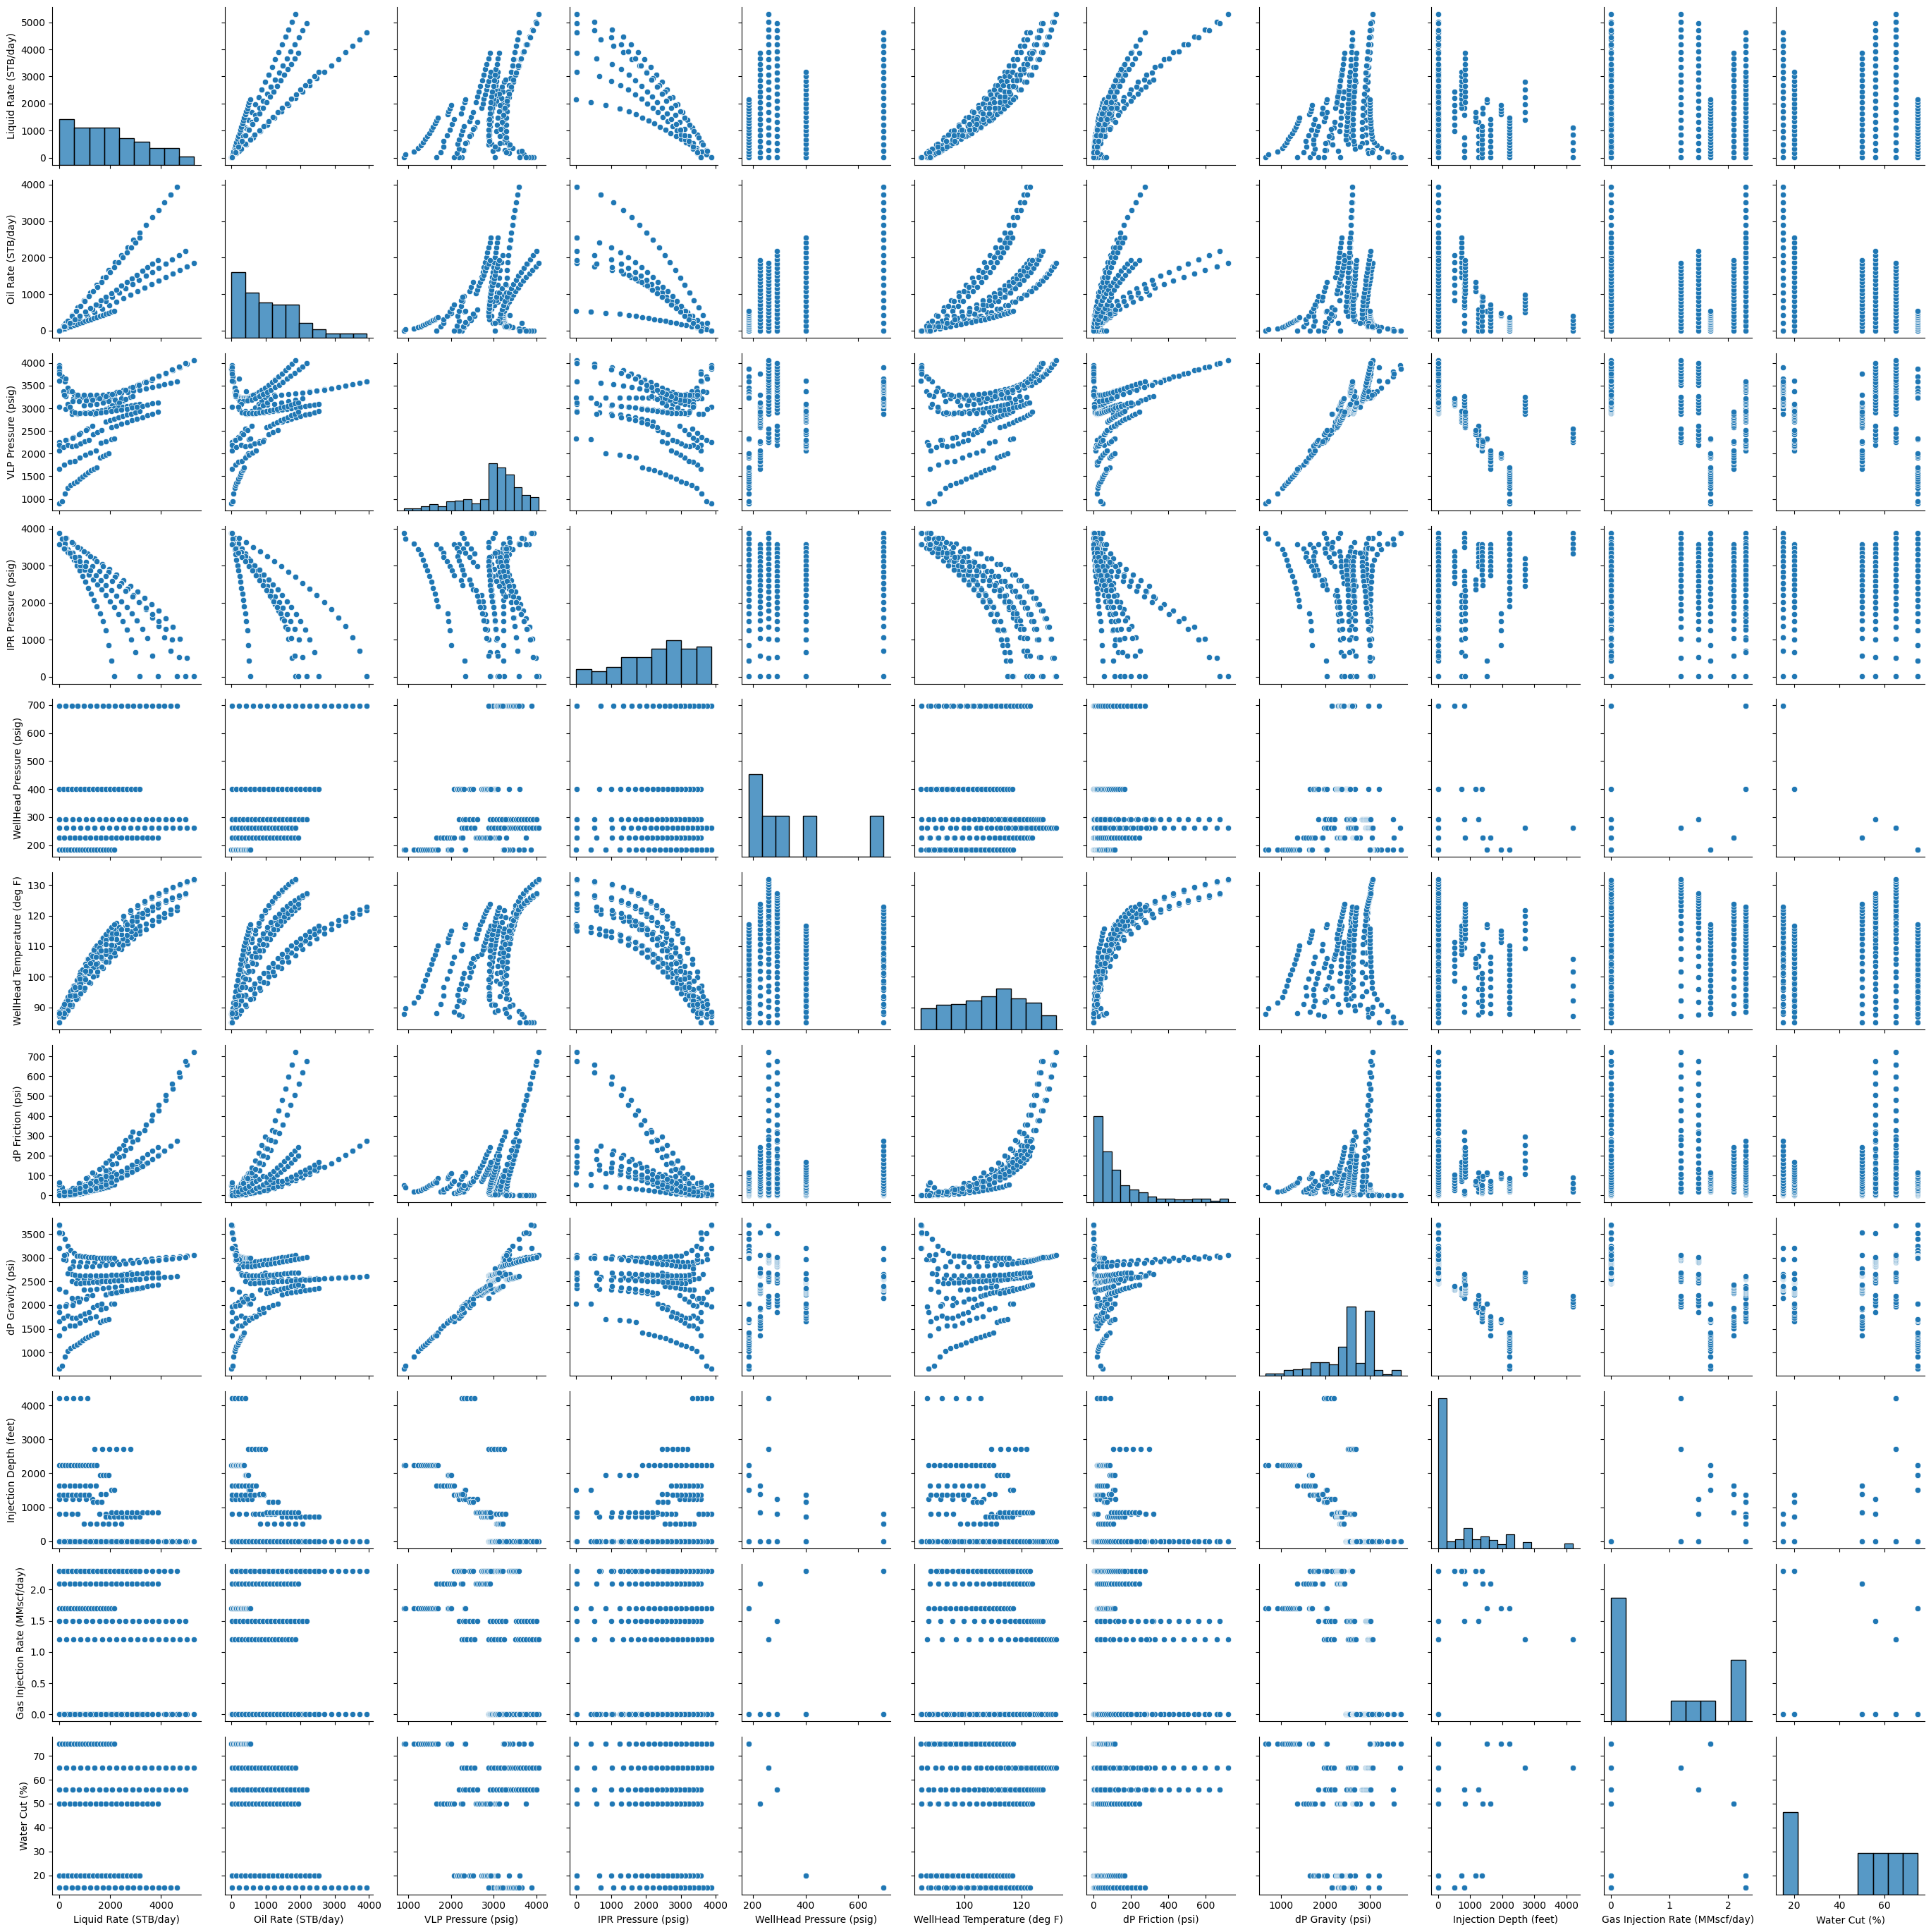

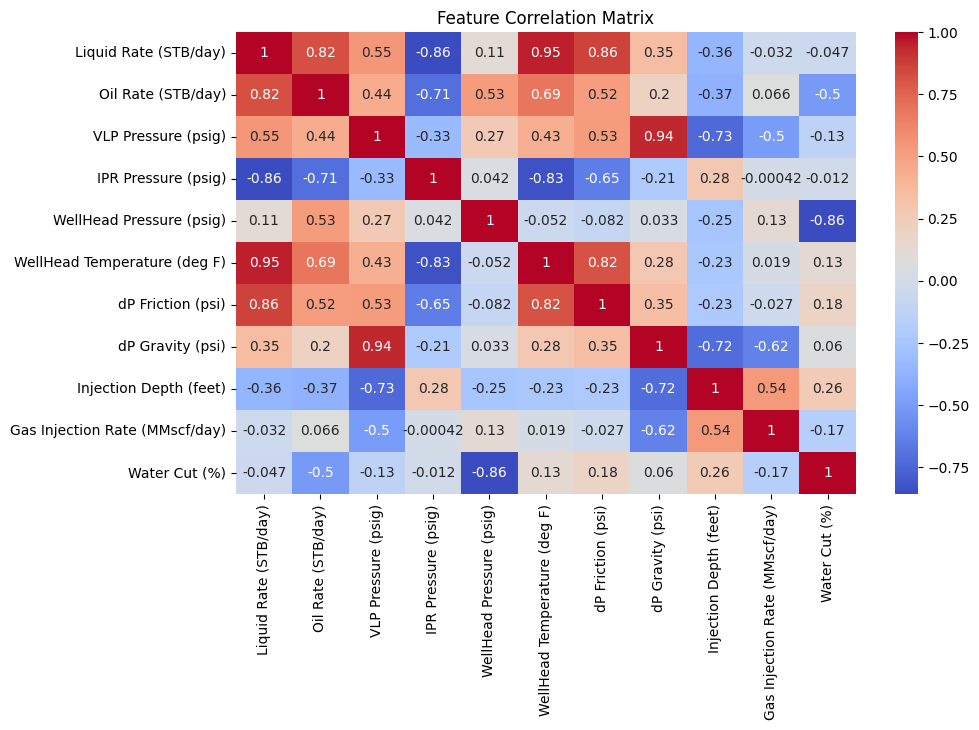

In [5]:
# Pairplot
sns.pairplot(df)
plt.tight_layout()
plt.show()

# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# PAIR PLOT
 1. Strong Linear and Nonlinear Relationships:
•	VLP Pressure vs dP Gravity:
A strong, direct linear relationship is clearly visible. This aligns with the correlation coefficient of 0.94 from the correlation matrix. Gravity plays a direct role in bottom-hole pressure buildup.
•	VLP Pressure vs dP Friction:
A moderately strong positive relationship is also visible, indicating that as frictional pressure drop increases, VLP pressure tends to rise.
•	VLP Pressure vs Injection Depth:
A negative trend exists — deeper injection correlates with lower VLP pressure, suggesting optimal gas injection depths help reduce bottom-hole pressure.
 2. Weak or No Clear Relationships:
•	VLP Pressure vs Gas Injection Rate:
The scatter plot appears widely spread, indicating low direct correlation, but nonlinear relationships may still exist.
•	VLP Pressure vs Water Cut:
No strong visual pattern exists here, supporting the weak correlation observed earlier (corr ≈ -0.13). Water Cut might not be a strong predictor of VLP pressure.
 3. Multicollinearity Observed Between:
•	Liquid Rate vs Wellhead Temp and dP Friction:
These show high positive relationships and tight groupings — could lead to multicollinearity in linear models. You may consider dimensionality reduction (e.g., PCA) if needed.
•	dP Gravity vs dP Friction:
Both are highly correlated, suggesting similar or interdependent effects on the well performance.
 4. Distribution Patterns (Diagonal Histograms):
•	Many features are skewed (e.g., Oil Rate, Injection Depth, Gas Rate) — you might need to consider:
o	Standardization or log transformation
o	Use of non-linear models like Random Forests or Gradient Boosting for better performance
 5. Data Patterns and Clustering:
•	Several scatter plots (e.g., Oil Rate vs dP Gravity) reveal banded structures or clusters, suggesting either:
o	Different operating regimes
o	Groupings by well or time
o	Inconsistent sampling or sensor precision
 Key ML Modeling Recommendations Based on the Pair Plot:
•	Top Predictors for VLP Pressure:
o	dP Gravity (strongest)
o	dP Friction
o	Liquid Rate
o	Injection Depth
•	Weak Predictors:
Water Cut, Gas Injection Rate (at least from visible patterns), this is because the gas injection rate was added manually, meanwhile the effect has already taken place during modelling, hence it is not conforming with what is expected.
•	Consider Polynomial or Tree-based models to capture non-linear trends.

# HEAT MAP
1. Strong Positive Correlations
These feature pairs move together — as one increases, so does the other:
•	Liquid Rate vs. Wellhead Temperature: 0.95
o	As the temperature at the wellhead increases, liquid production rate increases. This could suggest that higher energy (thermal expansion, pressure) facilitates higher fluid movement.
•	Liquid Rate vs. dP Friction: 0.86
o	High friction pressure drops are associated with higher liquid rates, which makes sense — more fluid flow usually leads to more resistance in the tubing.
•	VLP Pressure vs. dP Gravity: 0.94
o	Higher gravitational pressure drop contributes to increased VLP pressure.
2. Strong Negative Correlations
These features move in opposite directions:
•	Liquid Rate vs. IPR Pressure: -0.86
o	As inflow pressure increases, liquid production tends to decrease. This could reflect suboptimal drawdown or buildup pressure due to restricted flow.
•	Wellhead Pressure vs. Water Cut: -0.86
o	Higher water cut (i.e., more water in production) reduces wellhead pressure significantly. This might be due to more free gas or reduced oil mobility.
•	VLP Pressure vs. Injection Depth: -0.73
o	Deeper gas injection leads to lower VLP pressure, indicating gas lift efficiency: injecting deeper reduces the bottomhole flowing pressure needed to lift fluids.
3. Low/Negligible Correlations
Features that don’t appear to influence each other much:
•	Gas Injection Rate vs. Most Parameters:
o	Surprisingly weak correlation with VLP Pressure (-0.5), and Oil Rate (0.066), suggesting the gas lift efficiency might depend more on depth and not just gas volume.
•	Water Cut vs. Most Variables:
o	Water cut doesn’t strongly correlate with VLP, IPR, or dP Friction, suggesting water production might be driven by reservoir factors rather than lift conditions.
 Operational Insights for Gas Lift
•	Effective Gas Lift: Deep injection depth and appropriate friction and gravity drops are strongly linked with lower VLP pressure.
•	Optimizing Liquid Production: Maximize wellhead temperature and manage inflow pressure to improve liquid rates.
•	Monitoring Water Cut: High water cut significantly lowers wellhead pressure, which may hinder oil lifting and production pressure.


# FEATURE AND TARGET SELECTION

In [6]:
# Feature and target selection
X = df.drop(columns=["VLP Pressure (psig)"])
y = df["VLP Pressure (psig)"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale because our data columns has different unit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
def evaluate_model(model, X_test, y_test, model_name, plot=True):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Avoid division by zero in MAPE
    non_zero_idx = y_test != 0
    if np.any(non_zero_idx):
        mape = np.mean(np.abs((y_test[non_zero_idx] - y_pred[non_zero_idx]) / y_test[non_zero_idx])) * 100
    else:
        mape = np.nan  # Not computable if all targets are zero

    print(f"\n{model_name} Evaluation:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")

    if plot:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{model_name} - Actual vs Predicted")
        plt.tight_layout()
        plt.show()

    return y_pred, {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

# MODEL DEVELOPMENT

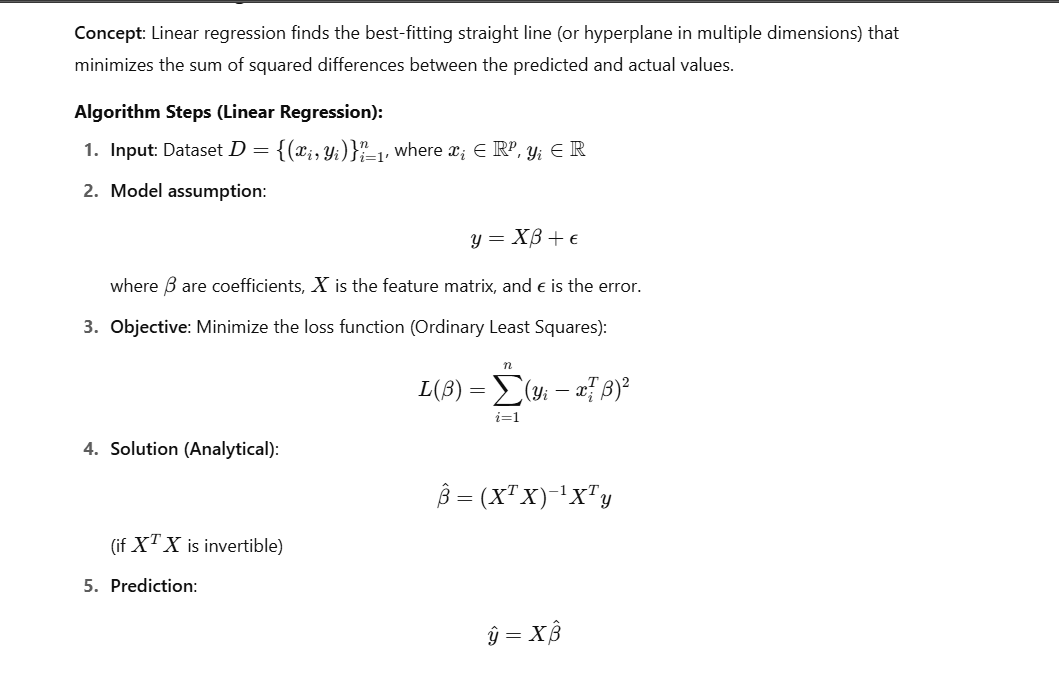


Linear Regression Evaluation:
MAE:  3.1809
RMSE: 4.1846
MAPE: 0.11%
R² Score: 1.0000


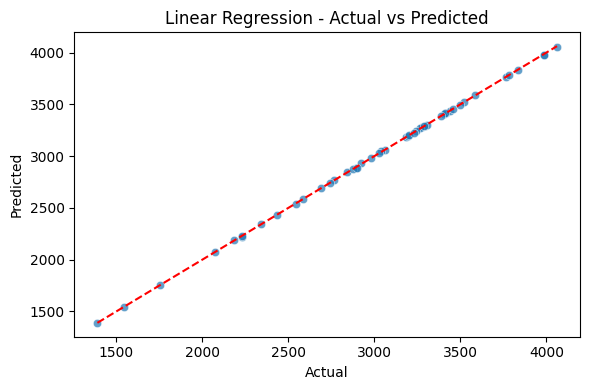

(array([2540.55218243, 3279.37536858, 3417.8658677 , 3185.09821354,
        3054.94163403, 2986.41571653, 2691.75283329, 3292.36771251,
        3406.90490976, 2431.80687721, 3295.93599881, 2886.28482877,
        3439.22165064, 2929.31359616, 3413.58532699, 2585.26410944,
        2222.91911389, 3763.44753662, 3525.78266914, 3196.82586003,
        3271.58075939, 4057.34783982, 2766.88615962, 3244.07862806,
        3049.38402247, 3202.30926742, 3457.20098414, 3291.69112738,
        2842.08754645, 3586.12330116, 3497.11785282, 2232.15983541,
        2873.31999279, 2194.18704375, 3980.50784161, 1544.38401288,
        2740.51477063, 3227.96083097, 2340.76152428, 3032.9108879 ,
        2070.74266457, 3389.3069873 , 1759.71202756, 3833.56819974,
        3781.24509343, 1389.96794666, 2889.64390007, 3980.45699111]),
 {'MAE': 3.180890116834121,
  'RMSE': np.float64(4.184644124828767),
  'MAPE': np.float64(0.11140682921746348),
  'R2': 0.999952982988492})

In [9]:
# ===============================
# Linear Regression
# ===============================
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
evaluate_model(lr, X_test_scaled, y_test, "Linear Regression")


Linear Regression Polynomia Evaluation:
MAE:  6.4170
RMSE: 19.4836
MAPE: 0.25%
R² Score: 0.9990


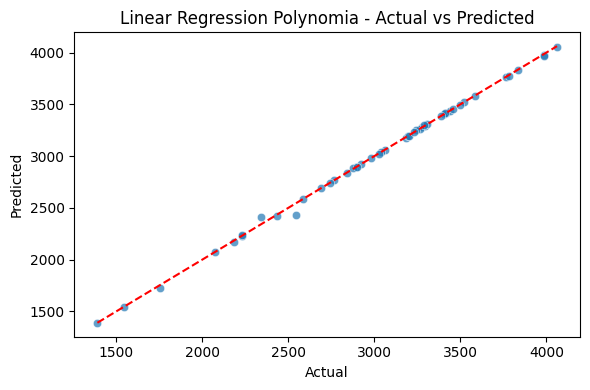

(array([2435.43482026, 3278.65663151, 3415.80017144, 3179.29079157,
        3057.61022563, 2978.58563521, 2691.36235891, 3294.82535589,
        3406.14704125, 2422.75663785, 3306.11234291, 2891.59407351,
        3435.92843694, 2925.51929615, 3412.17715629, 2588.68431855,
        2229.82954498, 3761.07196384, 3521.65502221, 3192.42100757,
        3265.92862356, 4057.41274273, 2766.03422794, 3249.41315291,
        3040.48193333, 3196.64821445, 3455.24272782, 3296.34824627,
        2840.39582653, 3582.3720682 , 3497.51150692, 2238.90178519,
        2884.86896382, 2174.61296073, 3980.15338211, 1543.84769282,
        2743.13682132, 3228.5722929 , 2408.56827236, 3024.69948281,
        2071.81621742, 3389.59359618, 1728.57095828, 3831.30318721,
        3777.63442185, 1389.21491292, 2897.01290965, 3971.01828157]),
 {'MAE': 6.416990897070136,
  'RMSE': np.float64(19.483563919650557),
  'MAPE': np.float64(0.25455630150409336),
  'R2': 0.9989807639829054})

In [10]:
# To account for the non linearity of the gas injection rate, polynomial Features is used
# to make a pipeline for Linear Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model_ply = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model_ply.fit(X_train_scaled, y_train)
evaluate_model(model_ply, X_test_scaled, y_test, "Linear Regression Polynomia")

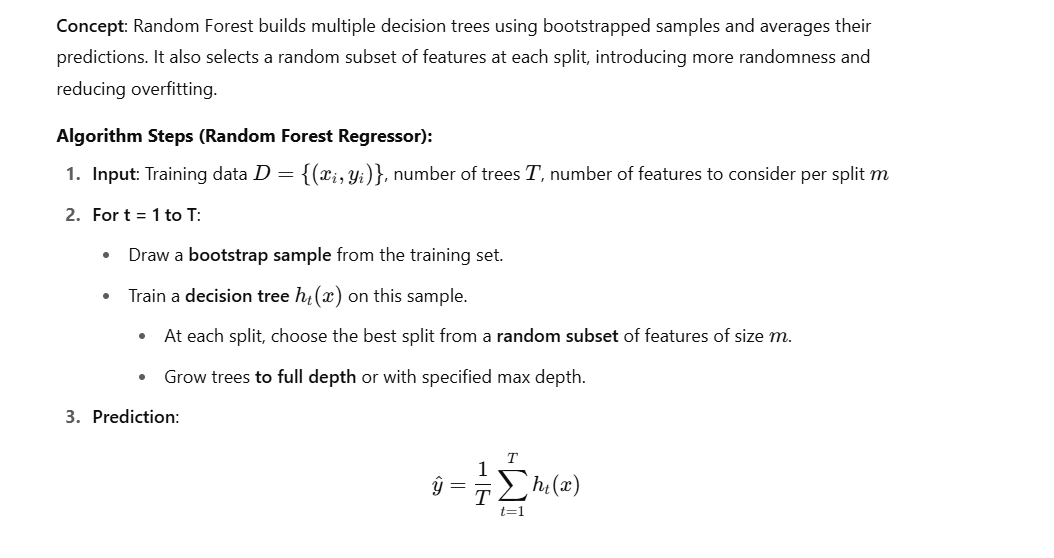

Best Random Forest Params: {'max_depth': 10, 'n_estimators': 100}

Random Forest Regressor Evaluation:
MAE:  27.9845
RMSE: 49.3080
MAPE: 0.99%
R² Score: 0.9935


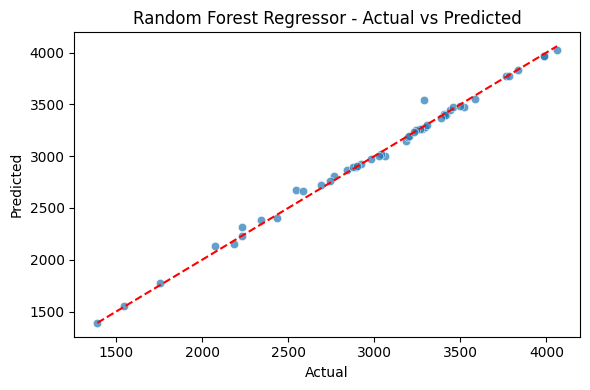

(array([2674.4669    , 3263.40631637, 3393.17481607, 3146.055725  ,
        3004.9307    , 2974.2509906 , 2721.22491   , 3281.44652393,
        3405.88489242, 2398.0371    , 3299.11487071, 2894.43501   ,
        3447.7841    , 2928.43793321, 3392.4996875 , 2659.305     ,
        2225.95393333, 3769.66666667, 3472.44501389, 3183.82396935,
        3262.86429869, 4026.1071    , 2809.16084429, 3252.07583   ,
        3023.76681537, 3196.80217056, 3476.68140337, 3538.08906667,
        2863.8984381 , 3555.5083    , 3482.92376667, 2319.55873333,
        2899.61384833, 2154.3187    , 3970.4812    , 1550.0428    ,
        2756.39771667, 3230.14092796, 2384.8233    , 2996.96785188,
        2131.4902    , 3372.23243083, 1778.8213    , 3836.03266667,
        3777.0808    , 1390.219     , 2904.40682063, 3970.5828    ]),
 {'MAE': 27.98447172391553,
  'RMSE': np.float64(49.30798560858008),
  'MAPE': np.float64(0.9940909435741123),
  'R2': 0.9934721151965329})

In [11]:
# ===============================
# Random Forest Regressor (with GridSearch)
# ===============================
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
print(f"Best Random Forest Params: {rf.best_params_}")
evaluate_model(rf.best_estimator_, X_test_scaled, y_test, "Random Forest Regressor")


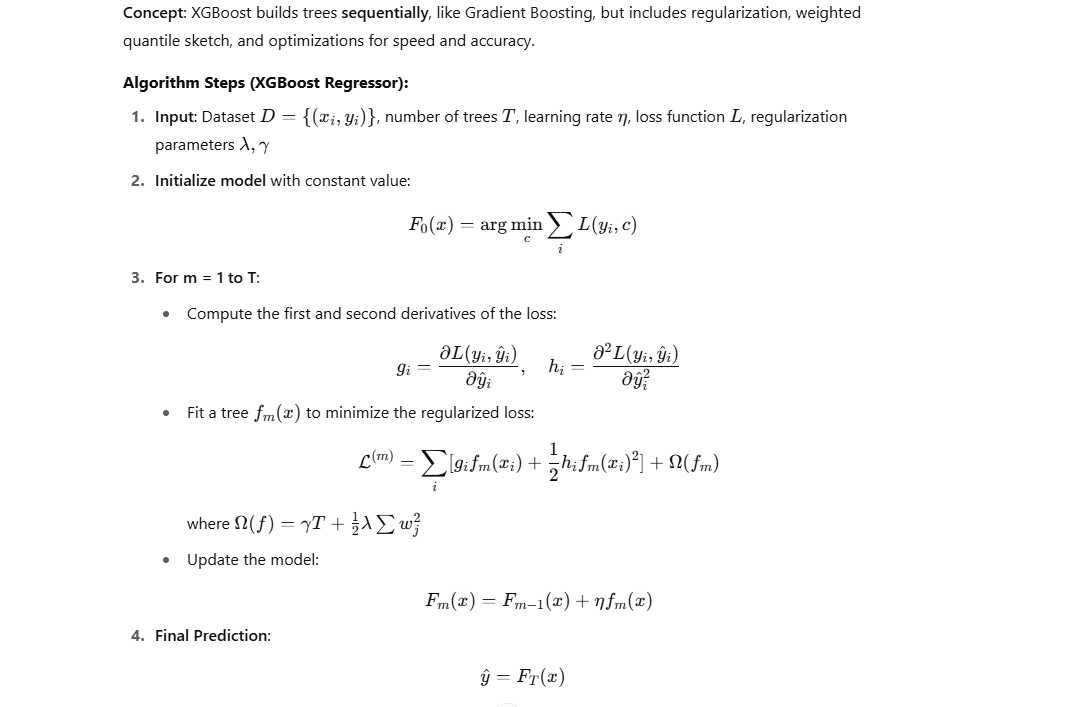

Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}

XGBoost Regressor Evaluation:
MAE:  34.3286
RMSE: 63.8450
MAPE: 1.24%
R² Score: 0.9891


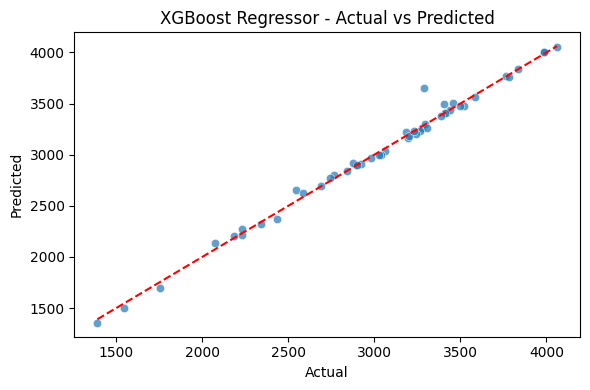

(array([2655.0615, 3265.1003, 3404.2278, 3217.82  , 3040.6838, 2964.4136,
        2691.3835, 3298.2795, 3500.4858, 2370.2827, 3263.4373, 2895.8613,
        3440.0151, 2913.3374, 3403.128 , 2624.8237, 2218.7844, 3765.9373,
        3473.088 , 3164.8384, 3231.7847, 4054.7886, 2805.3662, 3202.1335,
        2996.8127, 3180.397 , 3509.5562, 3656.0413, 2845.1838, 3566.792 ,
        3480.207 , 2272.1392, 2922.133 , 2206.515 , 4002.5164, 1498.2861,
        2767.3696, 3229.778 , 2318.398 , 2996.8872, 2131.9307, 3381.9714,
        1696.2424, 3833.825 , 3761.8748, 1354.8693, 2900.0151, 4002.5164],
       dtype=float32),
 {'MAE': 34.328551737467414,
  'RMSE': np.float64(63.844968891058556),
  'MAPE': np.float64(1.235513911013878),
  'R2': 0.9890556160592072})

In [12]:
# ===============================
# XGBoost Regressor (with GridSearch)
# ===============================
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
xgbr = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=3, n_jobs=-1)
xgbr.fit(X_train_scaled, y_train)
print(f"Best XGBoost Params: {xgbr.best_params_}")
evaluate_model(xgbr.best_estimator_, X_test_scaled, y_test, "XGBoost Regressor")


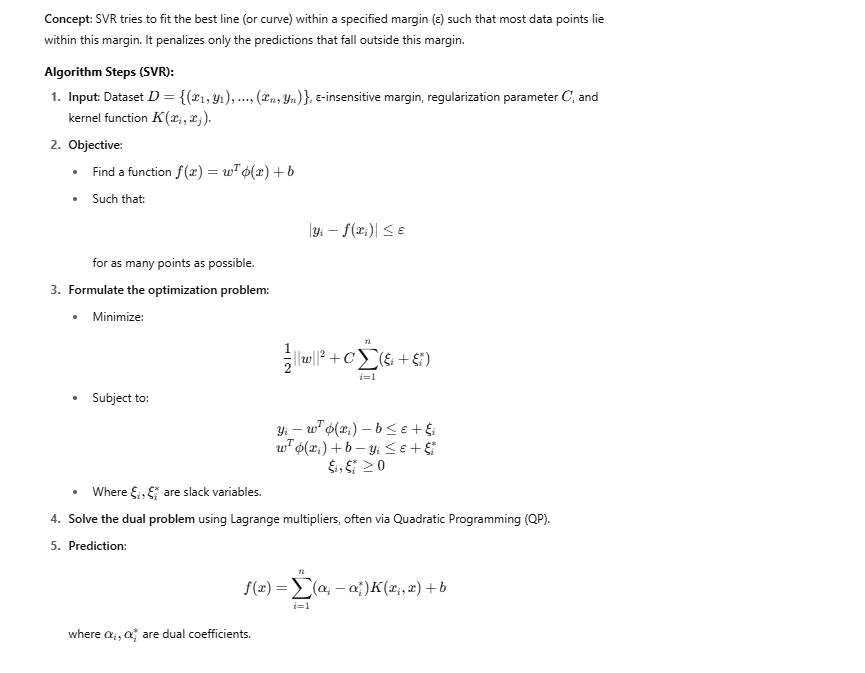

Best SVR Params: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}

Support Vector Regressor Evaluation:
MAE:  47.0383
RMSE: 85.4146
MAPE: 1.99%
R² Score: 0.9804


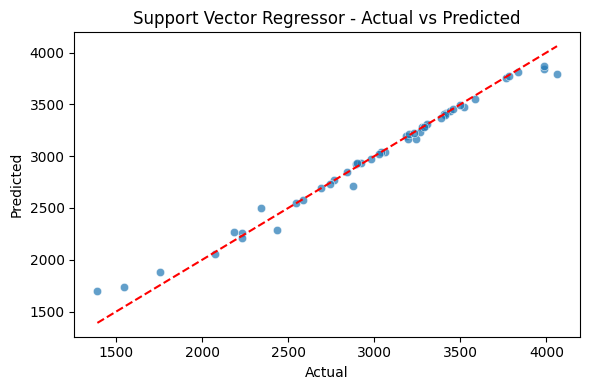

(array([2551.03738911, 3277.28734701, 3416.43080786, 3196.96542906,
        3037.0705969 , 2975.75013284, 2695.90330343, 3295.14148062,
        3405.44019568, 2290.4801686 , 3311.2579076 , 2920.45253389,
        3433.17750989, 2931.96352307, 3400.25167662, 2573.79323757,
        2262.11641959, 3757.94284358, 3478.68219638, 3165.60617967,
        3233.71177587, 3794.31471958, 2771.56068792, 3160.95290481,
        3041.19538362, 3215.26402572, 3455.88077846, 3278.65538687,
        2845.57248452, 3550.65637533, 3493.71881009, 2210.33163595,
        2709.01577281, 2263.61889703, 3844.91817987, 1741.08837924,
        2731.30083246, 3225.88487555, 2500.83767695, 3023.48984593,
        2050.68310167, 3367.51016213, 1878.46633096, 3810.18938804,
        3774.66772037, 1697.80993576, 2932.93287048, 3874.68304671]),
 {'MAE': 47.03830956023314,
  'RMSE': np.float64(85.41461457908254),
  'MAPE': np.float64(1.993690150074376),
  'R2': 0.9804114480884276})

In [13]:
# ===============================
# Support Vector Regressor (SVR with GridSearch)
# ===============================
svr_params = {
    'C': [10, 100],
    'epsilon': [0.1, 0.2],
    'kernel': ['rbf']
}
svr = GridSearchCV(SVR(), svr_params, cv=3, n_jobs=-1)
svr.fit(X_train_scaled, y_train)
print(f"Best SVR Params: {svr.best_params_}")
evaluate_model(svr.best_estimator_, X_test_scaled, y_test, "Support Vector Regressor")


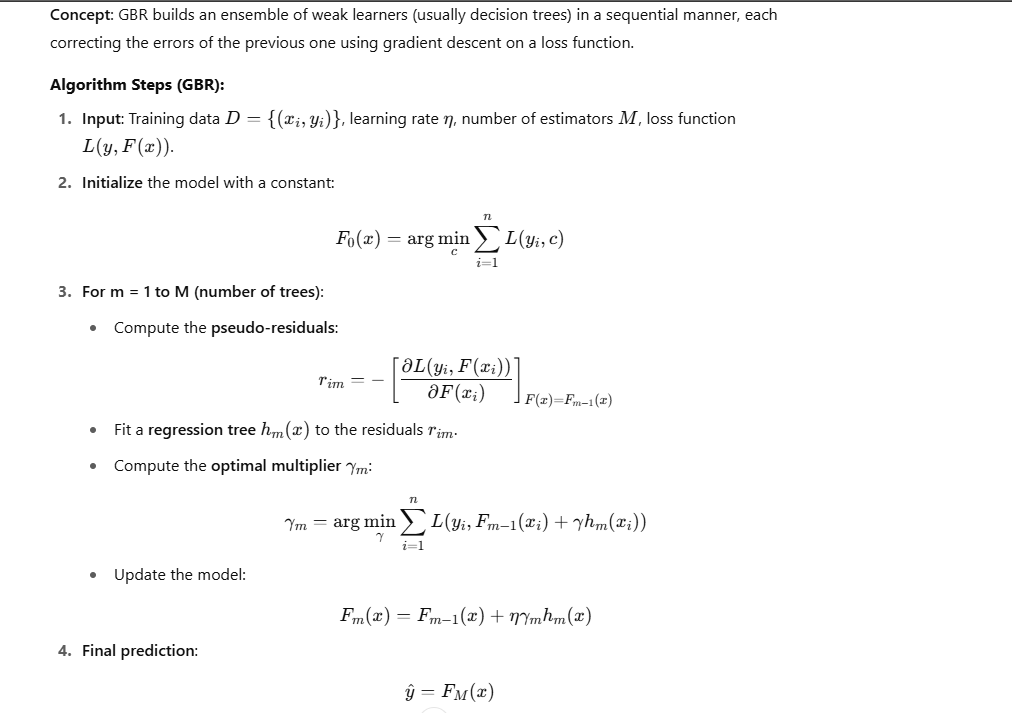

Best GBR Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Gradient Boosting Regressor Evaluation:
MAE:  27.4092
RMSE: 41.8253
MAPE: 1.00%
R² Score: 0.9953


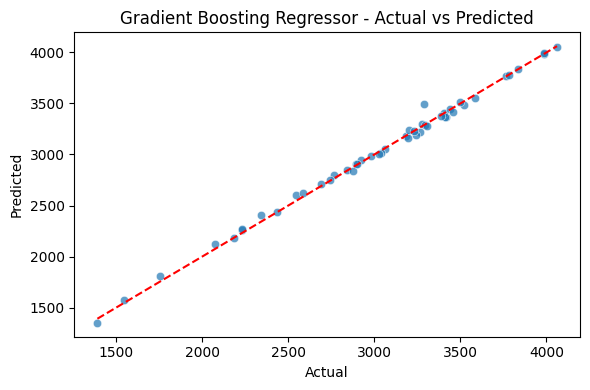

(array([2602.38774295, 3302.57180081, 3364.9715219 , 3185.39538693,
        3057.04550317, 2983.78088213, 2714.60182123, 3288.74493531,
        3405.43501111, 2433.78902156, 3281.86742308, 2910.14046812,
        3441.23454906, 2941.41819557, 3364.9715219 , 2619.97524124,
        2258.86335791, 3766.04382275, 3482.49859119, 3163.75775682,
        3223.48056068, 4052.25373021, 2803.66407881, 3192.25278191,
        3015.3323522 , 3236.65340071, 3414.09617273, 3494.6383374 ,
        2852.88290645, 3552.43532839, 3512.72074952, 2266.64880648,
        2841.87808086, 2186.22623134, 3988.24704436, 1572.11146019,
        2754.36839134, 3227.95666656, 2402.59815396, 2999.95393836,
        2120.95278761, 3373.77536828, 1812.77721249, 3833.88446802,
        3781.95124469, 1349.81760997, 2909.09825954, 3996.86869905]),
 {'MAE': 27.40918190743456,
  'RMSE': np.float64(41.8252578218953),
  'MAPE': np.float64(1.0035132339733648),
  'R2': 0.9953030578168921})

In [14]:
# ===============================
# Gradient Boosting Regressor (with GridSearch)
# ===============================
gbr_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), gbr_params, cv=3, n_jobs=-1)
gbr.fit(X_train_scaled, y_train)
print(f"Best GBR Params: {gbr.best_params_}")
evaluate_model(gbr.best_estimator_, X_test_scaled, y_test, "Gradient Boosting Regressor")


# VISUAL MODEL EVALUATION

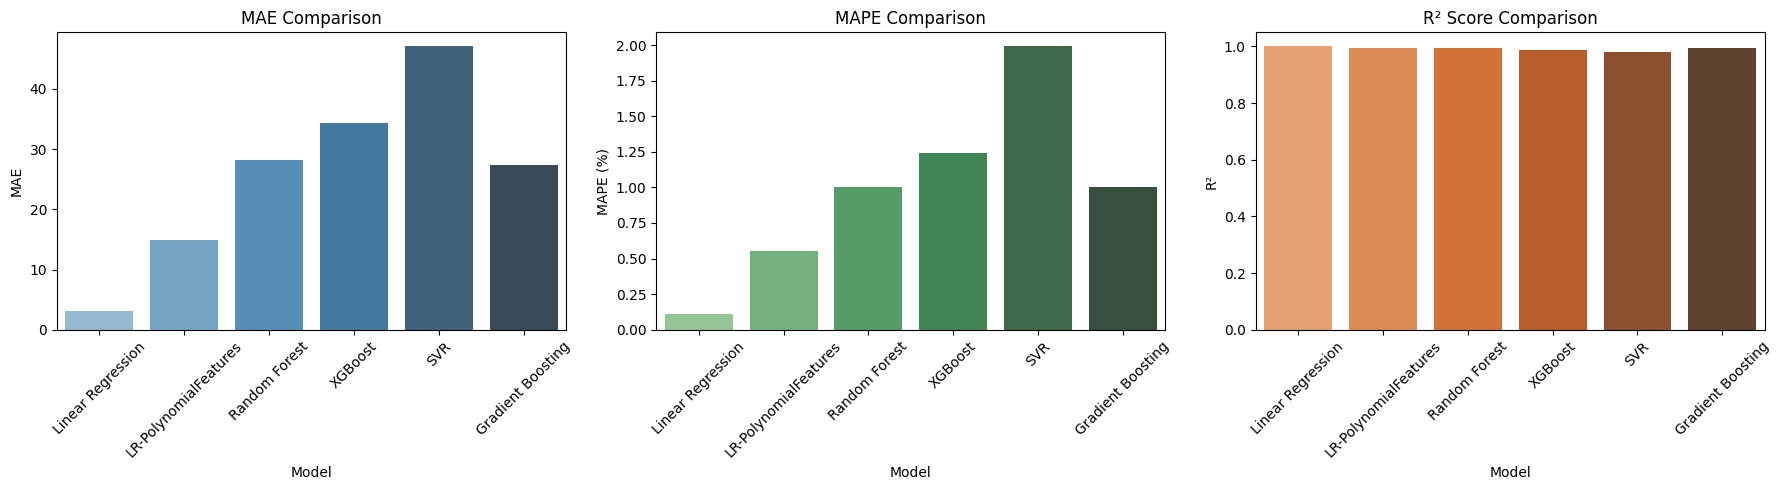

In [15]:

# model scores
model_scores = {
    "Model": ["Linear Regression", "LR-PolynomialFeatures", "Random Forest", "XGBoost", "SVR", "Gradient Boosting"],
    "MAE": [3.18, 14.897, 28.1305, 34.3286, 47.0383, 27.4092],
    "MAPE": [0.11, 0.55, 1.0, 1.24, 1.99, 1.0],
    "R2": [1.0, 0.9951, 0.9935, 0.9891, 0.9804, 0.9953]
}

df_scores = pd.DataFrame(model_scores)

# Plotting
plt.figure(figsize=(18, 5))

# MAE Plot
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='MAE', data=df_scores, palette='Blues_d')
plt.title('MAE Comparison')
plt.xticks(rotation=45)
plt.ylabel("MAE")

# MAPE Plot
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MAPE', data=df_scores, palette='Greens_d')
plt.title('MAPE Comparison')
plt.xticks(rotation=45)
plt.ylabel("MAPE (%)")

# R² Score Plot
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R2', data=df_scores, palette='Oranges_d')
plt.title('R² Score Comparison')
plt.xticks(rotation=45)
plt.ylabel("R²")

plt.tight_layout()
plt.show()


# API DEVELOPMENT

Gradient Boosting is the most appropriate model for this task due to its ability to handle nonlinear data while maintaining low prediction errors and high accuracy.


In [16]:
import gradio as gr

In [17]:
# Defining the prediction function
def predict_vlp(liquid_rate, oil_rate, ipr_pressure, wellhead_pressure, wellhead_temp,
                dp_friction, dp_gravity, injection_depth, gas_injection_rate, water_cut):

    # Create a DataFrame for input
    input_data = pd.DataFrame([[
        liquid_rate, oil_rate, ipr_pressure, wellhead_pressure, wellhead_temp,
        dp_friction, dp_gravity, injection_depth, gas_injection_rate, water_cut
    ]], columns=[
        'Liquid Rate (STB/day)', 'Oil Rate (STB/day)', 'IPR Pressure (psig)',
        'WellHead Pressure (psig)', 'WellHead Temperature (deg F)',
        'dP Friction (psi)', 'dP Gravity (psi)', 'Injection Depth (feet)',
        'Gas Injection Rate (MMscf/day)', 'Water Cut (%)'
    ])

    # Predict
    vlp_prediction = gbr.predict(input_data)[0]
    return f"Predicted VLP Pressure: {vlp_prediction:.2f} psig"

# Gradio interface
interface = gr.Interface(
    fn=predict_vlp,
    inputs=[
        gr.Number(label="Liquid Rate (STB/day)"),
        gr.Number(label="Oil Rate (STB/day)"),
        gr.Number(label="IPR Pressure (psig)"),
        gr.Number(label="WellHead Pressure (psig)"),
        gr.Number(label="WellHead Temperature (deg F)"),
        gr.Number(label="dP Friction (psi)"),
        gr.Number(label="dP Gravity (psi)"),
        gr.Number(label="Injection Depth (feet)"),
        gr.Number(label="Gas Injection Rate (MMscf/day)"),
        gr.Number(label="Water Cut (%)"),
    ],
    outputs="text",
    title="Gas Lift VLP Pressure Predictor",
    description="Enter well parameters to predict VLP pressure using a trained Gradient Boosting  model.")


In [ ]:
# Launch the app
interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0c98a01d3dbb2c6d93.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
